<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#Analytical-formula" data-toc-modified-id="Analytical-formula-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analytical formula</a></span></li><li><span><a href="#Test-using-propagator" data-toc-modified-id="Test-using-propagator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test using propagator</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Evolve-using-master-equation-solver" data-toc-modified-id="Evolve-using-master-equation-solver-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Evolve using master equation solver</a></span></li><li><span><a href="#Extract-PTM" data-toc-modified-id="Extract-PTM-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extract PTM</a></span><ul class="toc-item"><li><span><a href="#Ideal-case" data-toc-modified-id="Ideal-case-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Ideal case</a></span></li><li><span><a href="#With-decoherence" data-toc-modified-id="With-decoherence-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>With decoherence</a></span></li><li><span><a href="#Sweep-the-time-here" data-toc-modified-id="Sweep-the-time-here-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Sweep the time here</a></span></li></ul></li><li><span><a href="#Two-qubit-gate" data-toc-modified-id="Two-qubit-gate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Two-qubit gate</a></span><ul class="toc-item"><li><span><a href="#Definitions" data-toc-modified-id="Definitions-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Definitions</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#PTM" data-toc-modified-id="PTM-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>PTM</a></span></li><li><span><a href="#Sweep-t1-time" data-toc-modified-id="Sweep-t1-time-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Sweep t1 time</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#Three-qubits" data-toc-modified-id="Three-qubits-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Three qubits</a></span></li></ul></div>

# Preambles

/Users/longnguyen/Documents/GitHub/qtrl/qtrl/benchmarking/tomography.py:297: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p is not 'I':
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180


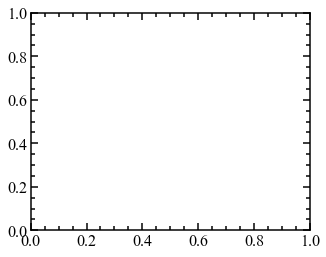

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from scipy.optimize import minimize
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
import scipy.linalg
from Fluxonium_hamiltonians import qchard_rotope as op
sys.path.append('/Users/longnguyen/Documents/GitHub/qtrl/')
from qtrl.benchmarking import tomography
from qtrl.analysis.state_tomography import generate_tomo_pulse_list, binary_arrays_to_bins, standard_tomography, \
    fidelity, purity, project_and_normalize_density_matrix, mcweeny_purification, dm_from_pulse, pauli_matrix, \
    renormalize_expectation_values, expectation_value_rho
from itertools import product
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

# Analytical formula

In [2]:

#Decoherence
def c_ops_func(t1, tphi):
    gamma1 = t1**(-1.0)
    gammaphi = t2**(-1.0)
#     gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sigmam())
    c2 = np.sqrt(gammaphi/2.0) *(sigmaz())
    return [c1, c2]

def gate_fidel_analytic(t_gate, t1, t2,n):
    d = 2**n
    gam1 = 1-np.exp(-t_gate/t1)
    gam2 = 1-np.exp(-t_gate*2.0/t2)
    generator = 2.0+2.0*np.sqrt(1.0-gam1)*np.sqrt(1.0-gam2)-gam1
    Fp = (generator**n)/(d**2)
    Fg = (d*Fp+1)/(d+1)
    return Fg

In [4]:
(1-gate_fidel_analytic(t_gate = 200, t1 = 500e3,t2=1e12,n=2))*1e4

3.1992017486714985

In [8]:
0.00014285183652085198*1e4

1.4285183652085198

# Test using propagator

3.4230840233462345e-06


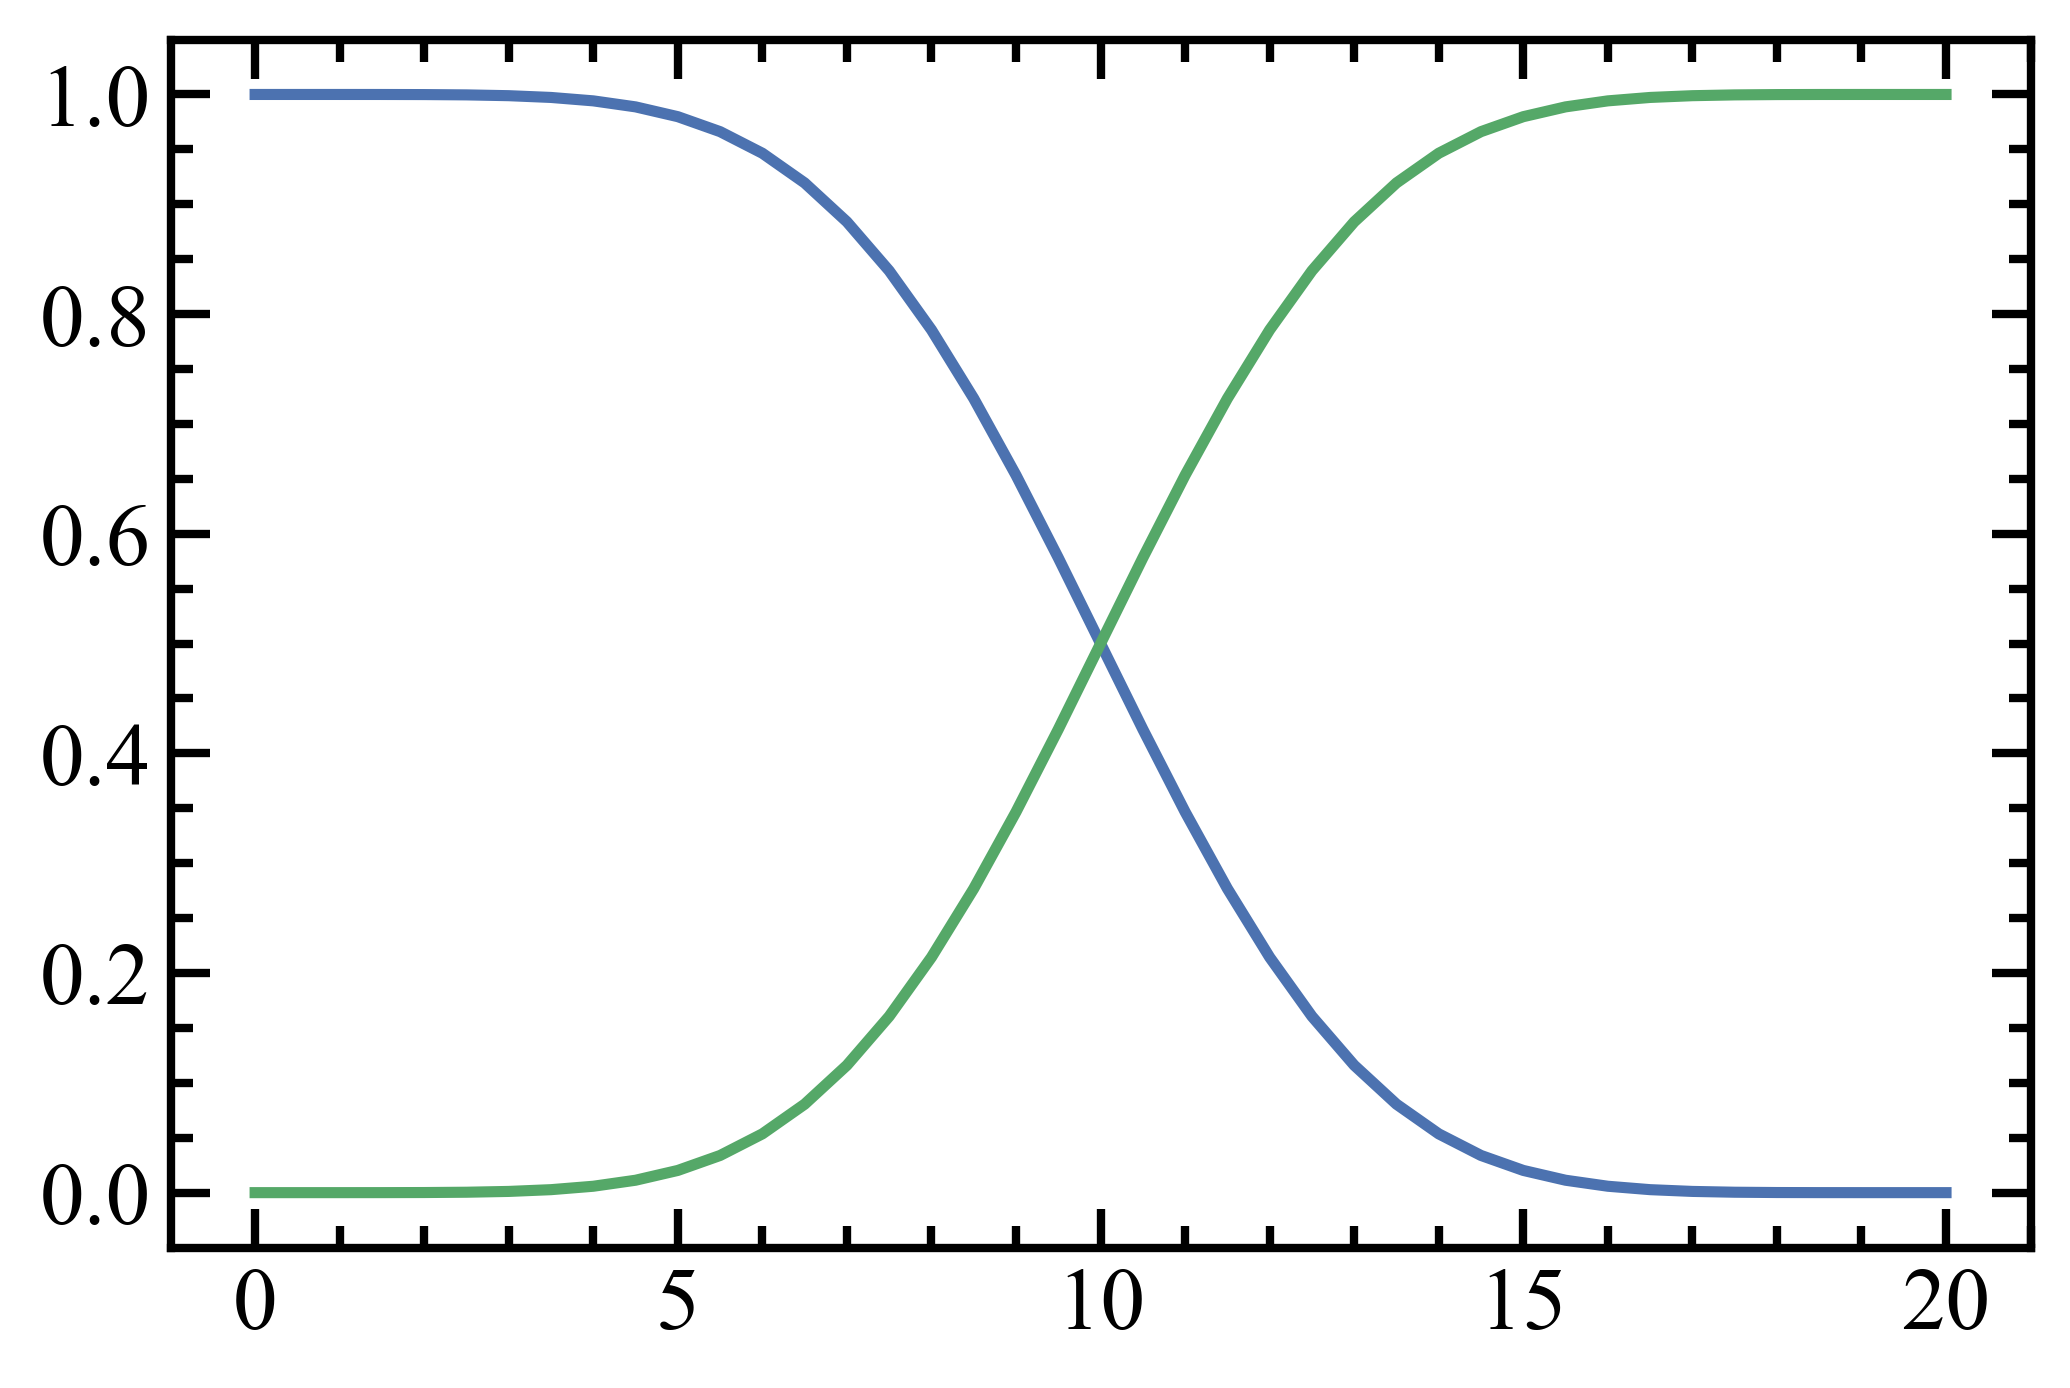

In [9]:
#Define qubit
wq = 5
H_nodrive = 0.5*wq*sigmaz()

#Define drive
T_gate = 20
shape = 'cos'
drive_freq = wq
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

#Evolve using propagator
# c_ops = c_ops(1e3, 1e3)
drag = False
drag_coeff = 0.0
U_ideal = sigmax()
state_0 = basis(2,0)
state_1 = basis(2,1)
P0 = state_0*state_0.dag()
P1 = state_1*state_1.dag()

coupl = 0.5 #MHz
# coupl = coupl*2*np.pi*1e-3
H_drive = coupl*sigmax()
H_dummy = 0*sigmax()
U_nothing = gates.evolution_operator_microwave(-H_nodrive, H_dummy, t_points=t_points,T_gate=T_gate, shape=shape, omega_d=drive_freq)
U_t = gates.evolution_operator_microwave(H_nodrive, H_drive, t_points=t_points,T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)

u0 = U_t[-1].matrix_element(state_0, state_0)
u1 = U_t[-1].matrix_element(state_1, state_1)

phase = np.angle(u1/u0)
single_qu_z = 0
single_qu_z = single_qu_z + state_0*state_0.dag()
single_qu_z = single_qu_z + np.exp(-1.0j*phase)*state_1*state_1.dag()
U_real = single_qu_z*U_t[-1]
U_real = U_t[-1]
U_real = U_nothing * U_t
U_real = U_real[-1]
    
plt.plot(t_points, expect(P0,U_t*state_0))
plt.plot(t_points, expect(P1,U_t*state_0))

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print (1-fidel)

# Optimization

In [22]:
drag = True
def infidelity(x):
    drag_coeff = x[0]
    delta_omega_d = x[1]
    drive_freq = wq + delta_omega_d
    U_t = gates.evolution_operator_microwave(H_nodrive, H_drive, t_points=t_points,T_gate=T_gate,
                                             DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    U_real = U_nothing * U_t
    U_real = U_real[-1]

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return abs(1 - fidel)
x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Nelder-Mead', tol = None)
print (infidelity(xopt.x))
print (xopt.x)

1.0133982542015474e-10
[7.13767017e-03 9.34192538e-06]


1.0133982542015474e-10


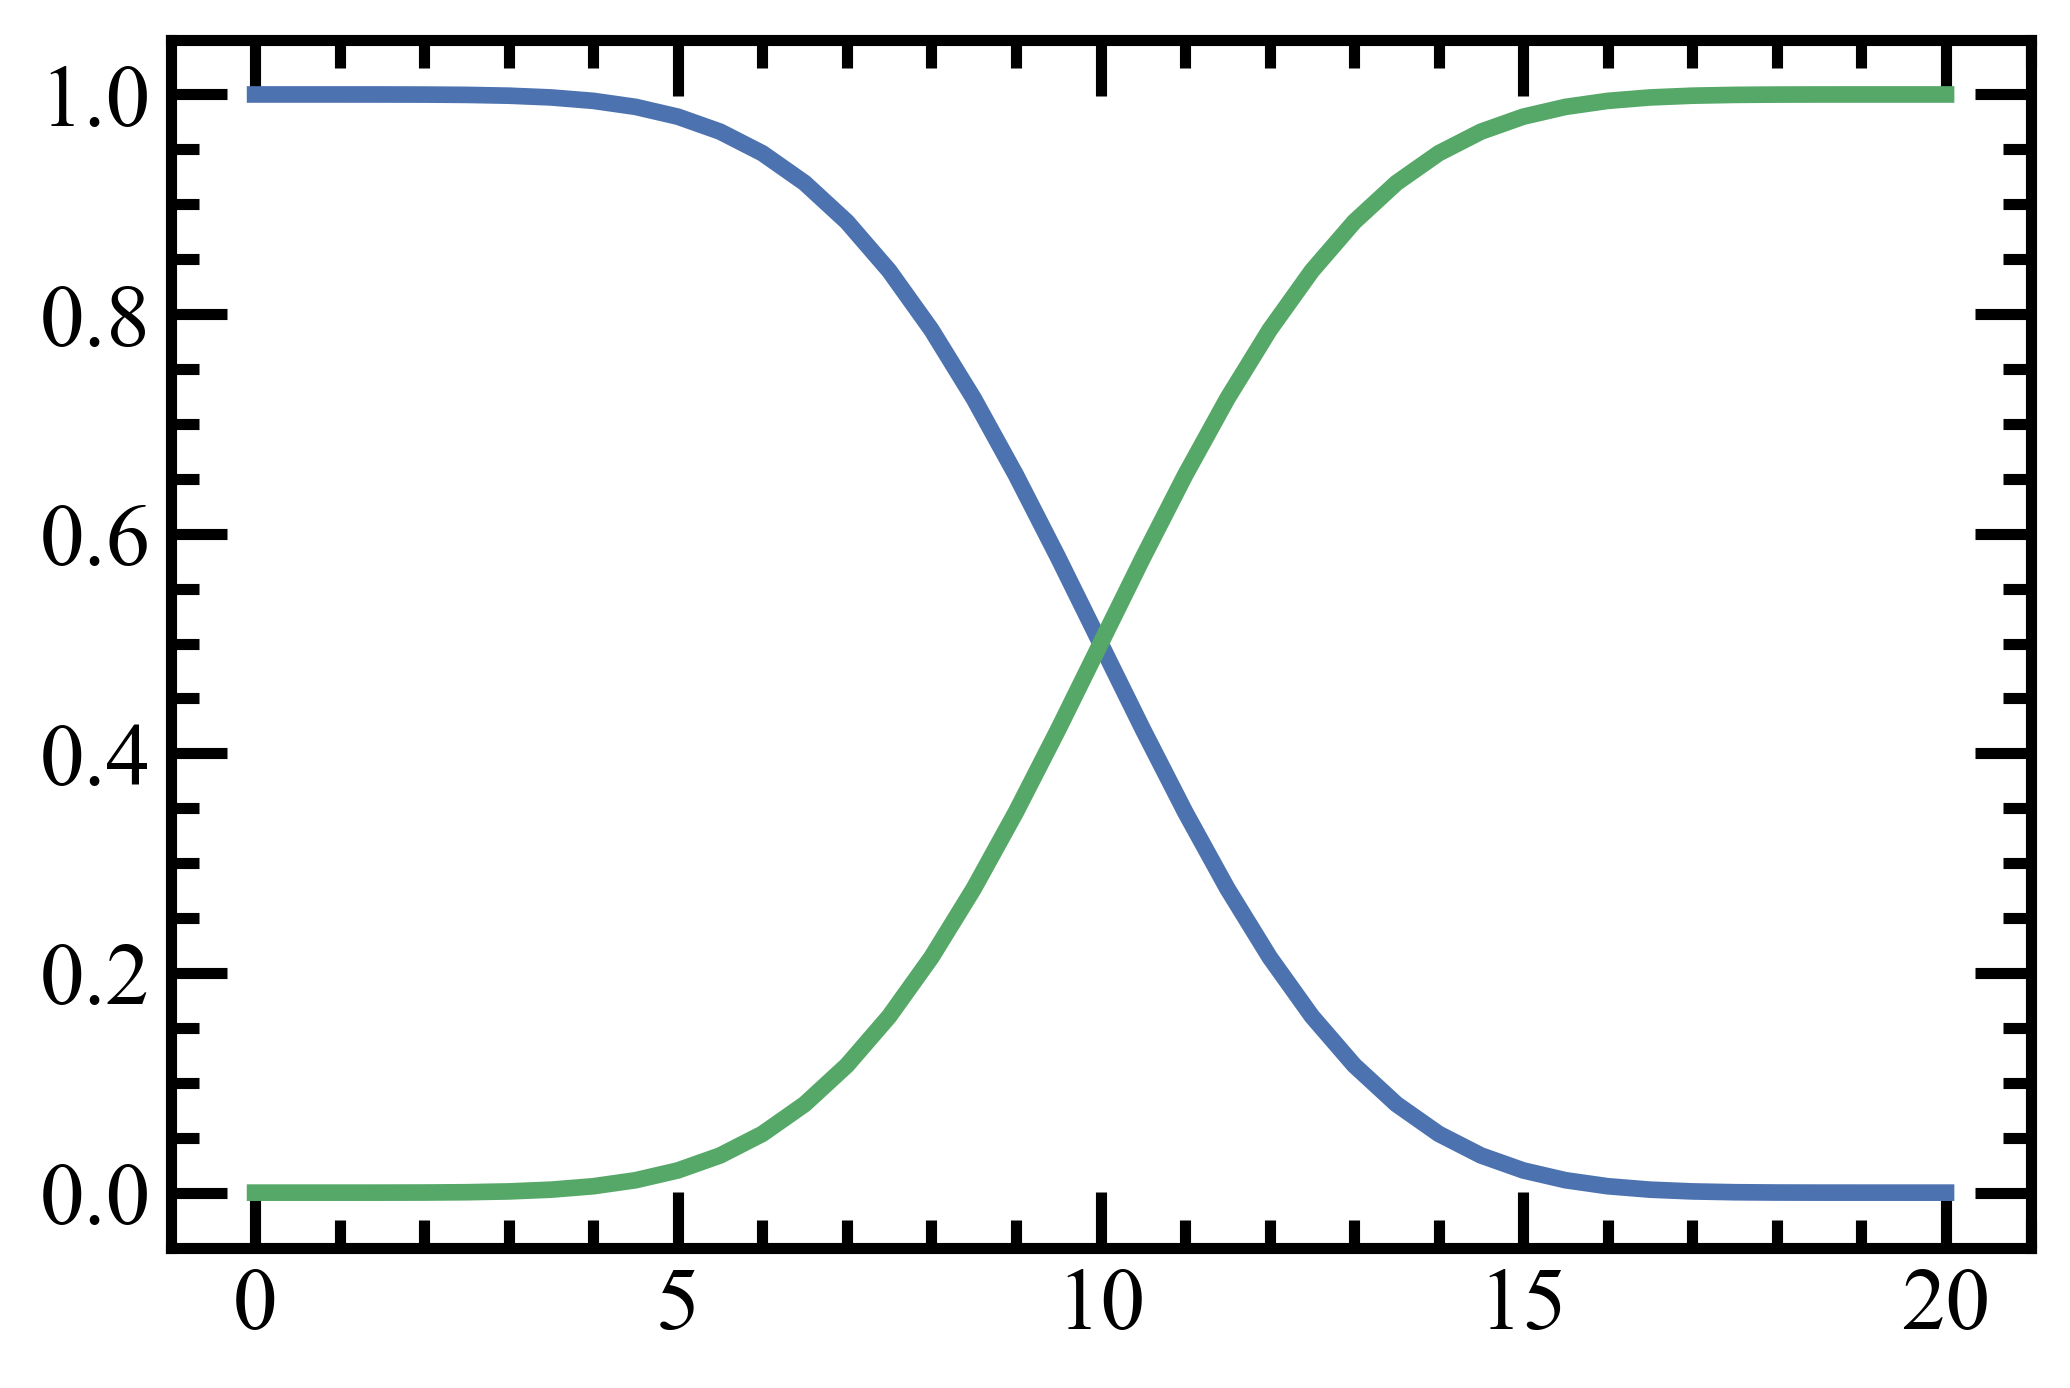

In [23]:
 drag_coeff = xopt.x[0]
delta_omega_d = xopt.x[1]
drive_freq = wq + delta_omega_d
U_t = gates.evolution_operator_microwave(H_nodrive, H_drive, t_points=t_points,T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)

u0 = U_t[-1].matrix_element(state_0, state_0)
u1 = U_t[-1].matrix_element(state_1, state_1)

phase = np.angle(u1/u0)
single_qu_z = 0
single_qu_z = single_qu_z + state_0*state_0.dag()
single_qu_z = single_qu_z + np.exp(-1.0j*phase)*state_1*state_1.dag()
U_real = single_qu_z*U_t[-1]
U_real = U_t[-1]
U_real = U_nothing * U_t
U_real = U_real[-1]
    
plt.plot(t_points, expect(P0,U_t*state_0))
plt.plot(t_points, expect(P1,U_t*state_0))

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print (1-fidel)

# Evolve using master equation solver

1.6046275419512313e-11
5.671065411716469e-06


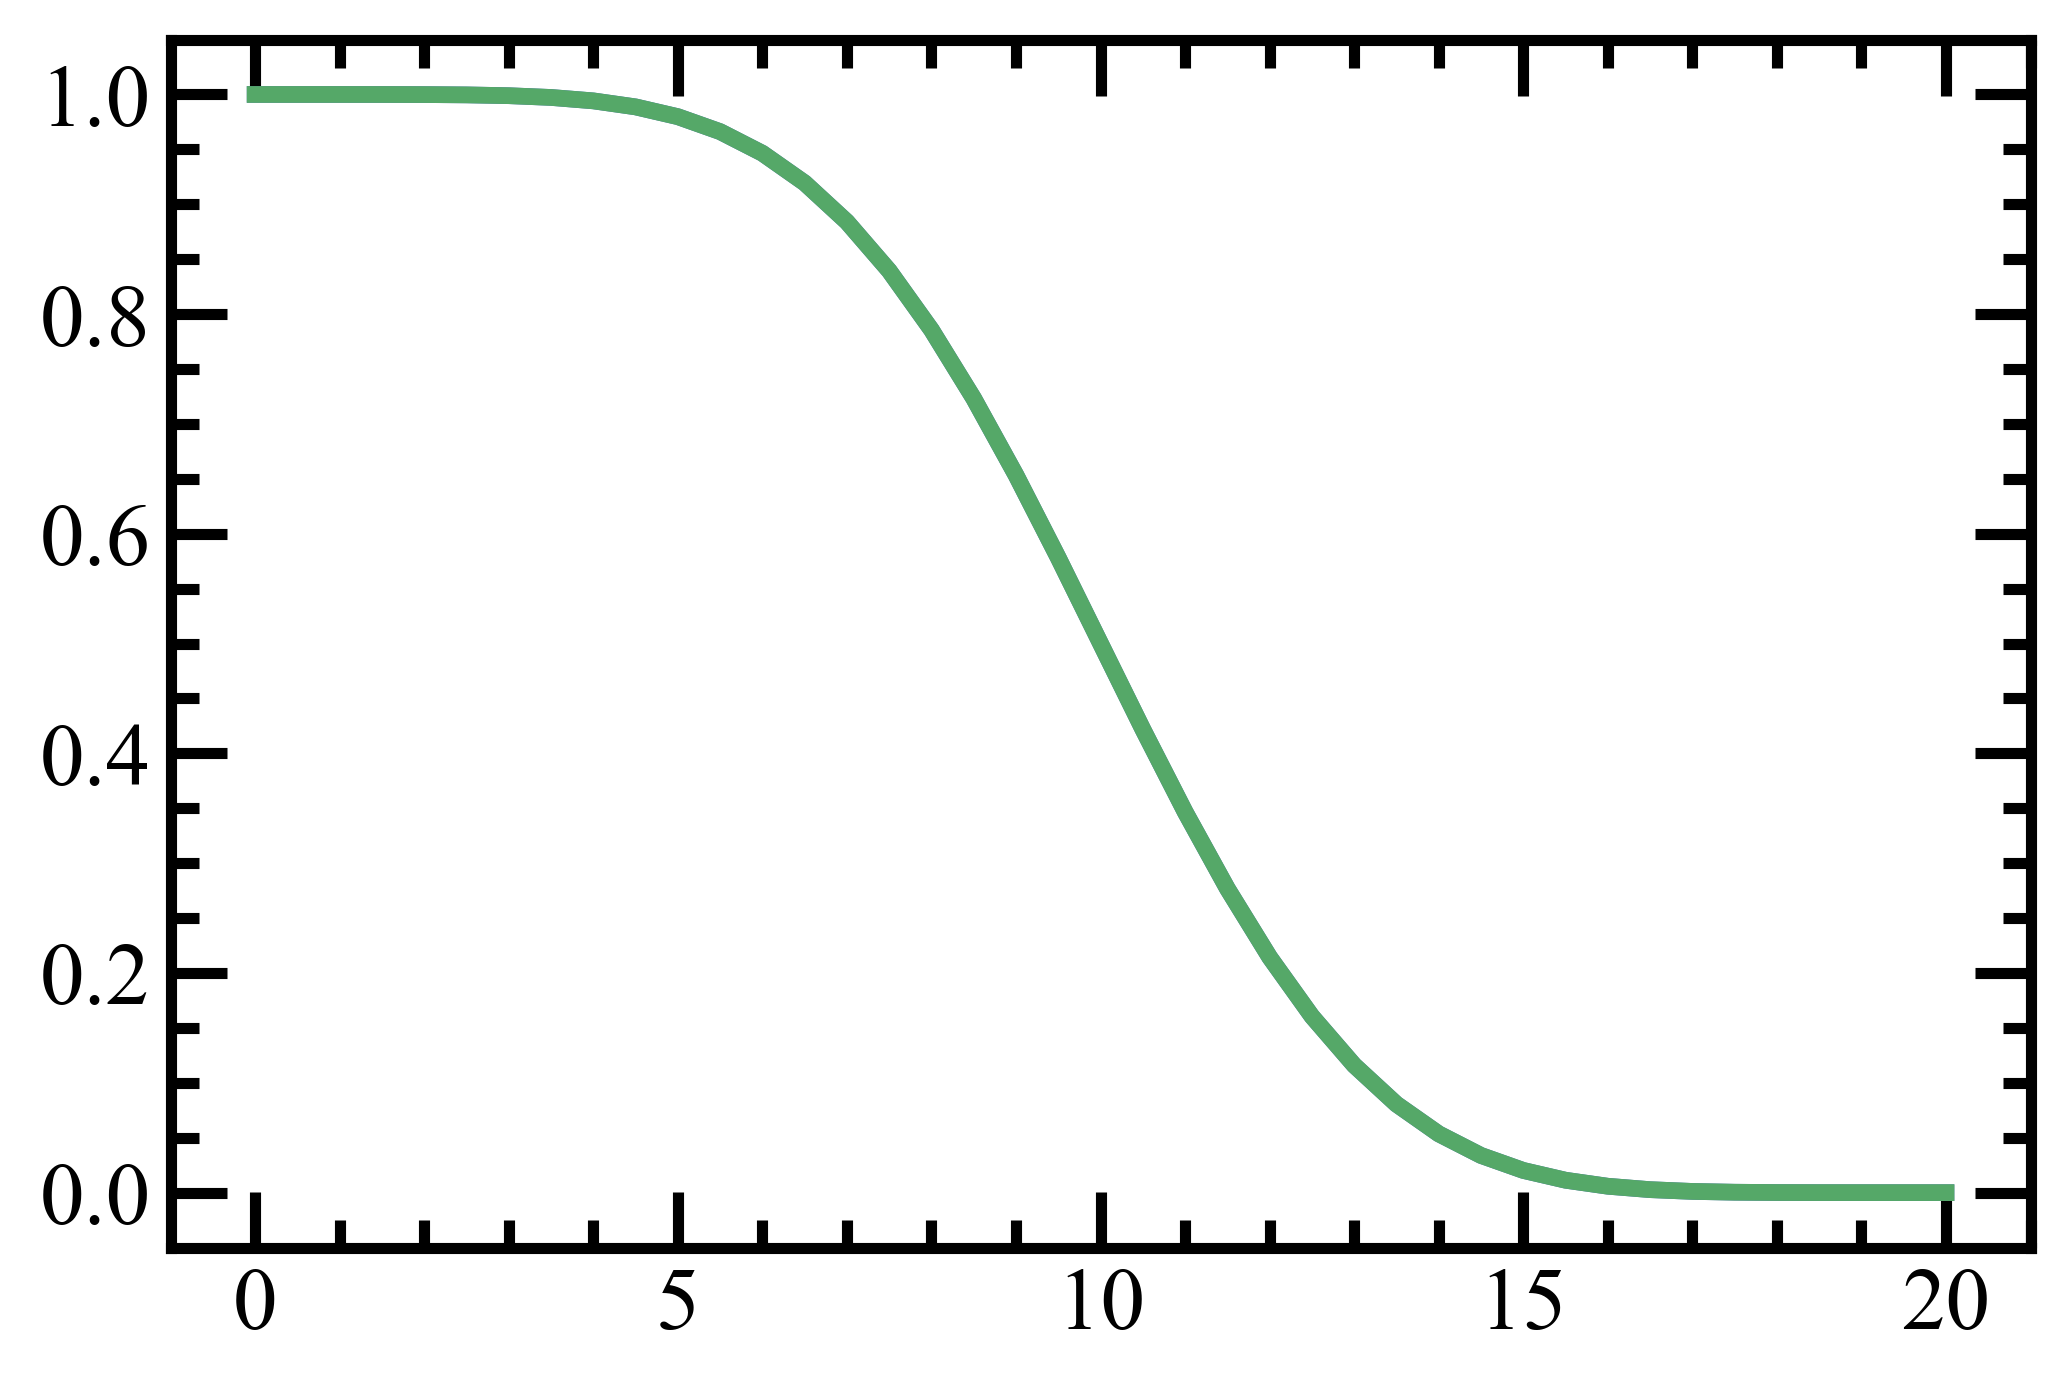

In [24]:
t1 = 1000e3
t2 = 1000e3
psi_ini = state_0
evol_states_veryideal = sigmax()*state_0
evol_states_ideal = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = [],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_ideal))

evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_real))

rho_veryideal = ket2dm(evol_states_veryideal)
rho_ideal = ket2dm(evol_states_ideal[-1])
rho_real = evol_states_real[-1]

print (1-qutip.fidelity(rho_ideal, rho_veryideal))
print (1-qutip.fidelity(rho_ideal, rho_real))
# fidel = (rho_real.sqrtm() * rho_ideal * rho_real.sqrtm()).sqrtm().tr()
# print (abs(fidel))

# Extract PTM

## Ideal case

<ipython-input-10-5f8ca780b90a>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89009ab160>)

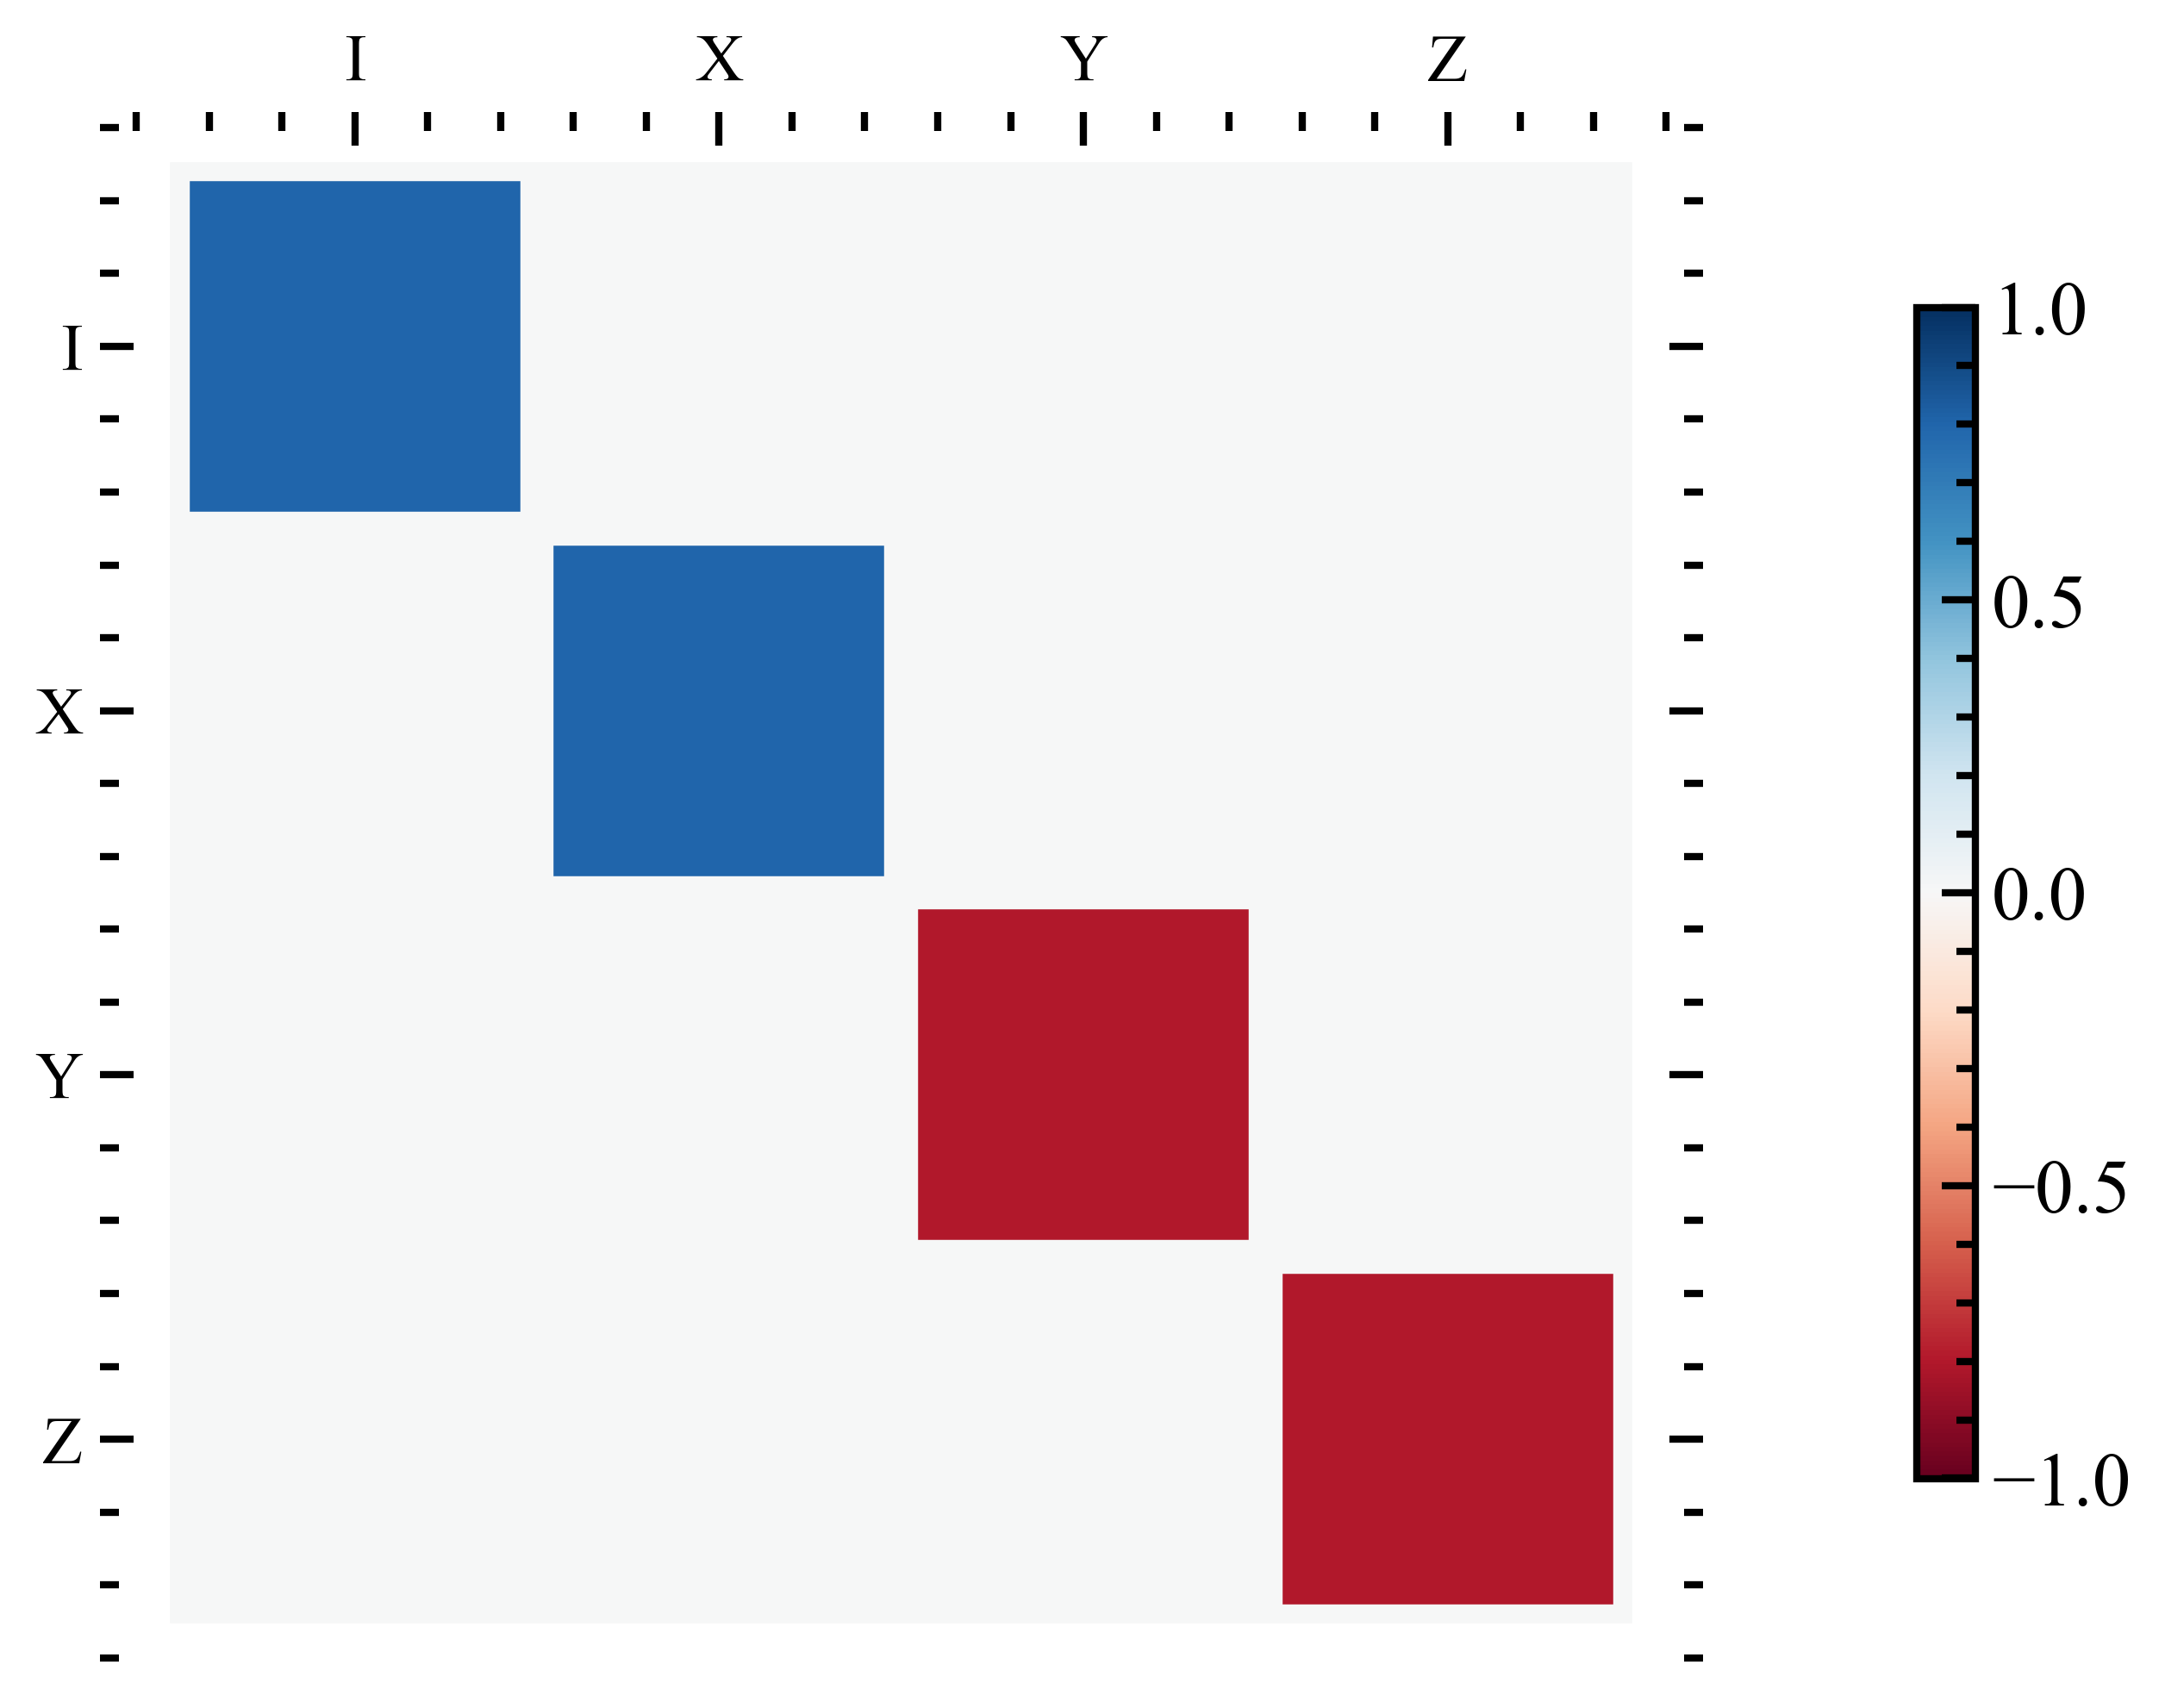

In [10]:
#Very ideal case
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
gate = sigmax()
states_in = []
states_out = []
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    psi_out = np.array(ket2dm(gate*psi_in))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)

ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)
# ptm_ideal_0 = np.round(ptm_ideal,10).real
# ptm_ideal_0 = ptm_ideal

<ipython-input-11-8c20d0497125>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


0.9999978822471323
2.8238310578743153e-09
0.9999978822471323


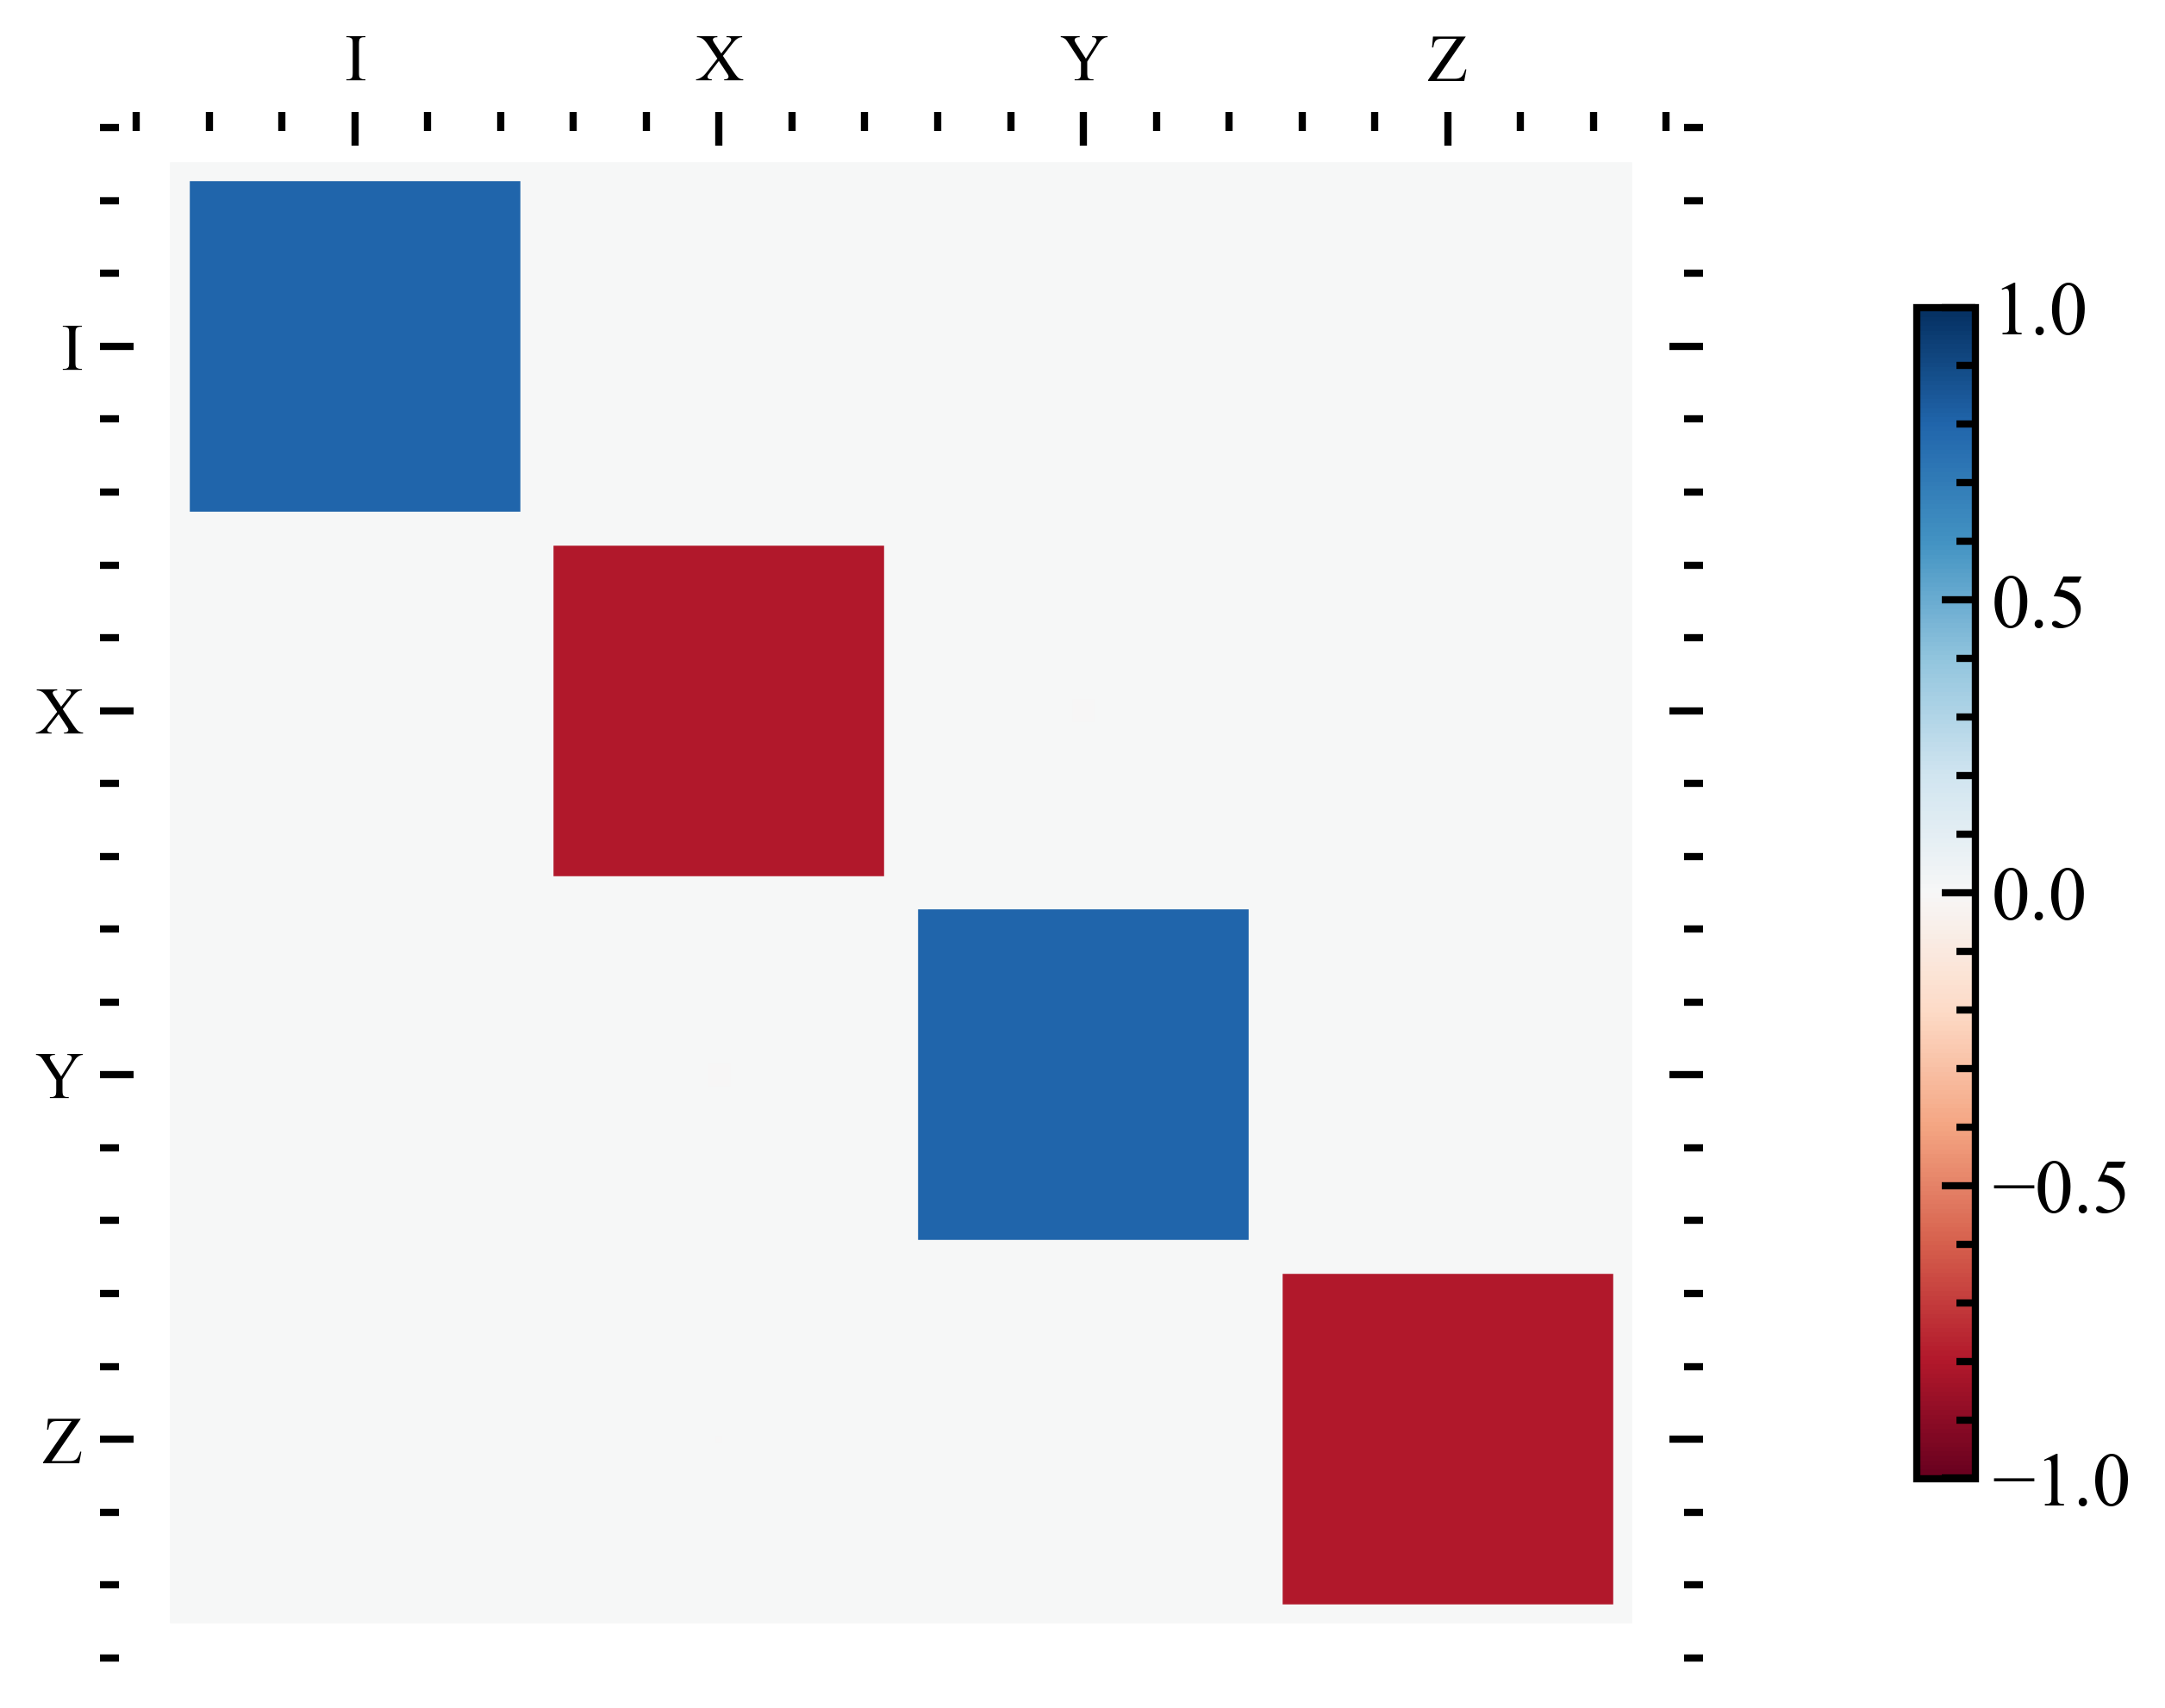

In [11]:
#Use master equation solver without collapse operators
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
states_in = []
states_out = []
 
drag = True
drag_coeff = 7.17991430e-03
delta_omega_d = 9.36328598e-06
drive_freq = wq + delta_omega_d
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = [],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    psi_out = np.array(ket2dm(single_qu_z*evol_states_real[-1]))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_real_noDephasing = tomography.get_process_matrix(states_in, states_out, physical=True)
# ptm_ideal_1 = np.round(ptm_ideal_1,2).real
qutip.hinton(ptm_real_noDephasing, xlabels = op_label, ylabels = op_label)

# d = 2
def ptm_fidel(ptm_real, ptm_ideal, d):
    return abs(np.trace(ptm_ideal.T @ ptm_real) / d ** 2)

# def gate_fidel(p_fidel,d):
#     return (d*p_fidel+1)/(d+1)

# # print (1-gate_fidel(ptm_fidel(ptm_ideal_1, ptm_ideal_0, d), d))
# # print (ptm_fidel(ptm_ideal, ptm_ideal, d))
print (1-tomography.process_fidelity(ptm_real_noDephasing, ptm_ideal))
print (1-tomography.process_fidelity(ptm_real_noDephasing, ptm_real_noDephasing))
print (1 - ptm_fidel(ptm_real_noDephasing, ptm_ideal, 2))

## With decoherence

In [12]:
#With decoherence
t1 = 100000e3 #unit is ns
t2 = 100e3 #unit is ns
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
states_in = []
states_out = []

gamma1 = t1**(-1.0)
gamma2 = t2**(-1.0)
c1 = np.sqrt(gamma1)*(sigmam())
c2 = np.sqrt(gamma2/2.0) *(sigmaz())
    
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = [c1,c2],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#     psi_out = np.array(evol_states_real[-1])
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
print (1-tomography.process_fidelity(ptm_real, ptm_real_noDephasing))
# print (1-tomography.process_fidelity(ptm_real, ptm_real))
# print (1-tomography.process_fidelity(ptm_real, ptm_ideal))

<ipython-input-12-518d91f82566>:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


9.998016745249583e-05


## Sweep the time here

In [13]:
shape = 'cos'
t1_array = np.linspace(10,1000,200)*1e3
t2 = 1e15
error_array_5 = np.zeros_like(t1_array)
error_array_20 = np.zeros_like(t1_array)
error_array_50 = np.zeros_like(t1_array)

# T_gate = 5
# t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
# drag = True
# drag_coeff_5 = 7.90601282e-03 
# delta_omega_d_5 =  9.35993386e-06
# drive_freq = wq + delta_omega_d_5
# for t2_idx, t2 in enumerate(t2_array):
#     states_in = []
#     states_out = []
#     for i, prep in enumerate(prep_ops):
#         psi_in = prep*state_0
#         evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = c_ops_func(t1, t2),
#                                                 T_gate=T_gate, sigma = sigma,DRAG = drag, DRAG_coefficient = drag_coeff_5, shape=shape, omega_d=drive_freq)
#         psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#         psi_in = np.array(ket2dm(psi_in))
#         states_in.append(psi_in)
#         states_out.append(psi_out)
#     ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
#     error_array_5[t2_idx]= 1.0-tomography.process_fidelity(ptm_real, ptm_ideal)

T_gate = 20
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
drag_coeff_20 = 7.17991430e-03
delta_omega_d_20 = 9.36328598e-06
drive_freq = wq + delta_omega_d_20
for t1_idx, t1 in enumerate(t1_array):
    gamma1 = t1**(-1.0)
    gamma2 = t2**(-1.0)
    c1 = np.sqrt(gamma1)*(sigmam())
    c2 = np.sqrt(gamma2/2.0) *(sigmaz())
    states_in = []
    states_out = []
    for i, prep in enumerate(prep_ops):
        psi_in = prep*state_0
        evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = [c1],
                                                T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff_20, shape=shape, omega_d=drive_freq)
        psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
        psi_in = np.array(ket2dm(psi_in))
        states_in.append(psi_in)
        states_out.append(psi_out)
    ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
    error_array_20[t1_idx]= 1.0-tomography.process_fidelity(ptm_real, ptm_real_noDephasing)
    
# T_gate = 50
# t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
# drag_coeff_50 = 3.26181655e-03 
# delta_omega_d_50 = 9.72628775e-06
# drive_freq = wq + delta_omega_d_50
# for t2_idx, t2 in enumerate(t2_array):
#     states_in = []
#     states_out = []
#     for i, prep in enumerate(prep_ops):
#         psi_in = prep*state_0
#         evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = c_ops_func(t1, t2),
#                                                 T_gate=T_gate, sigma = sigma,DRAG = drag, DRAG_coefficient = drag_coeff_50, shape=shape, omega_d=drive_freq)
#         psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#         psi_in = np.array(ket2dm(psi_in))
#         states_in.append(psi_in)
#         states_out.append(psi_out)
#     ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
#     error_array_50[t2_idx]= 1.0-tomography.process_fidelity(ptm_real, ptm_ideal)


In [14]:
np.save('1Q decoherence error.npy', error_array_20)

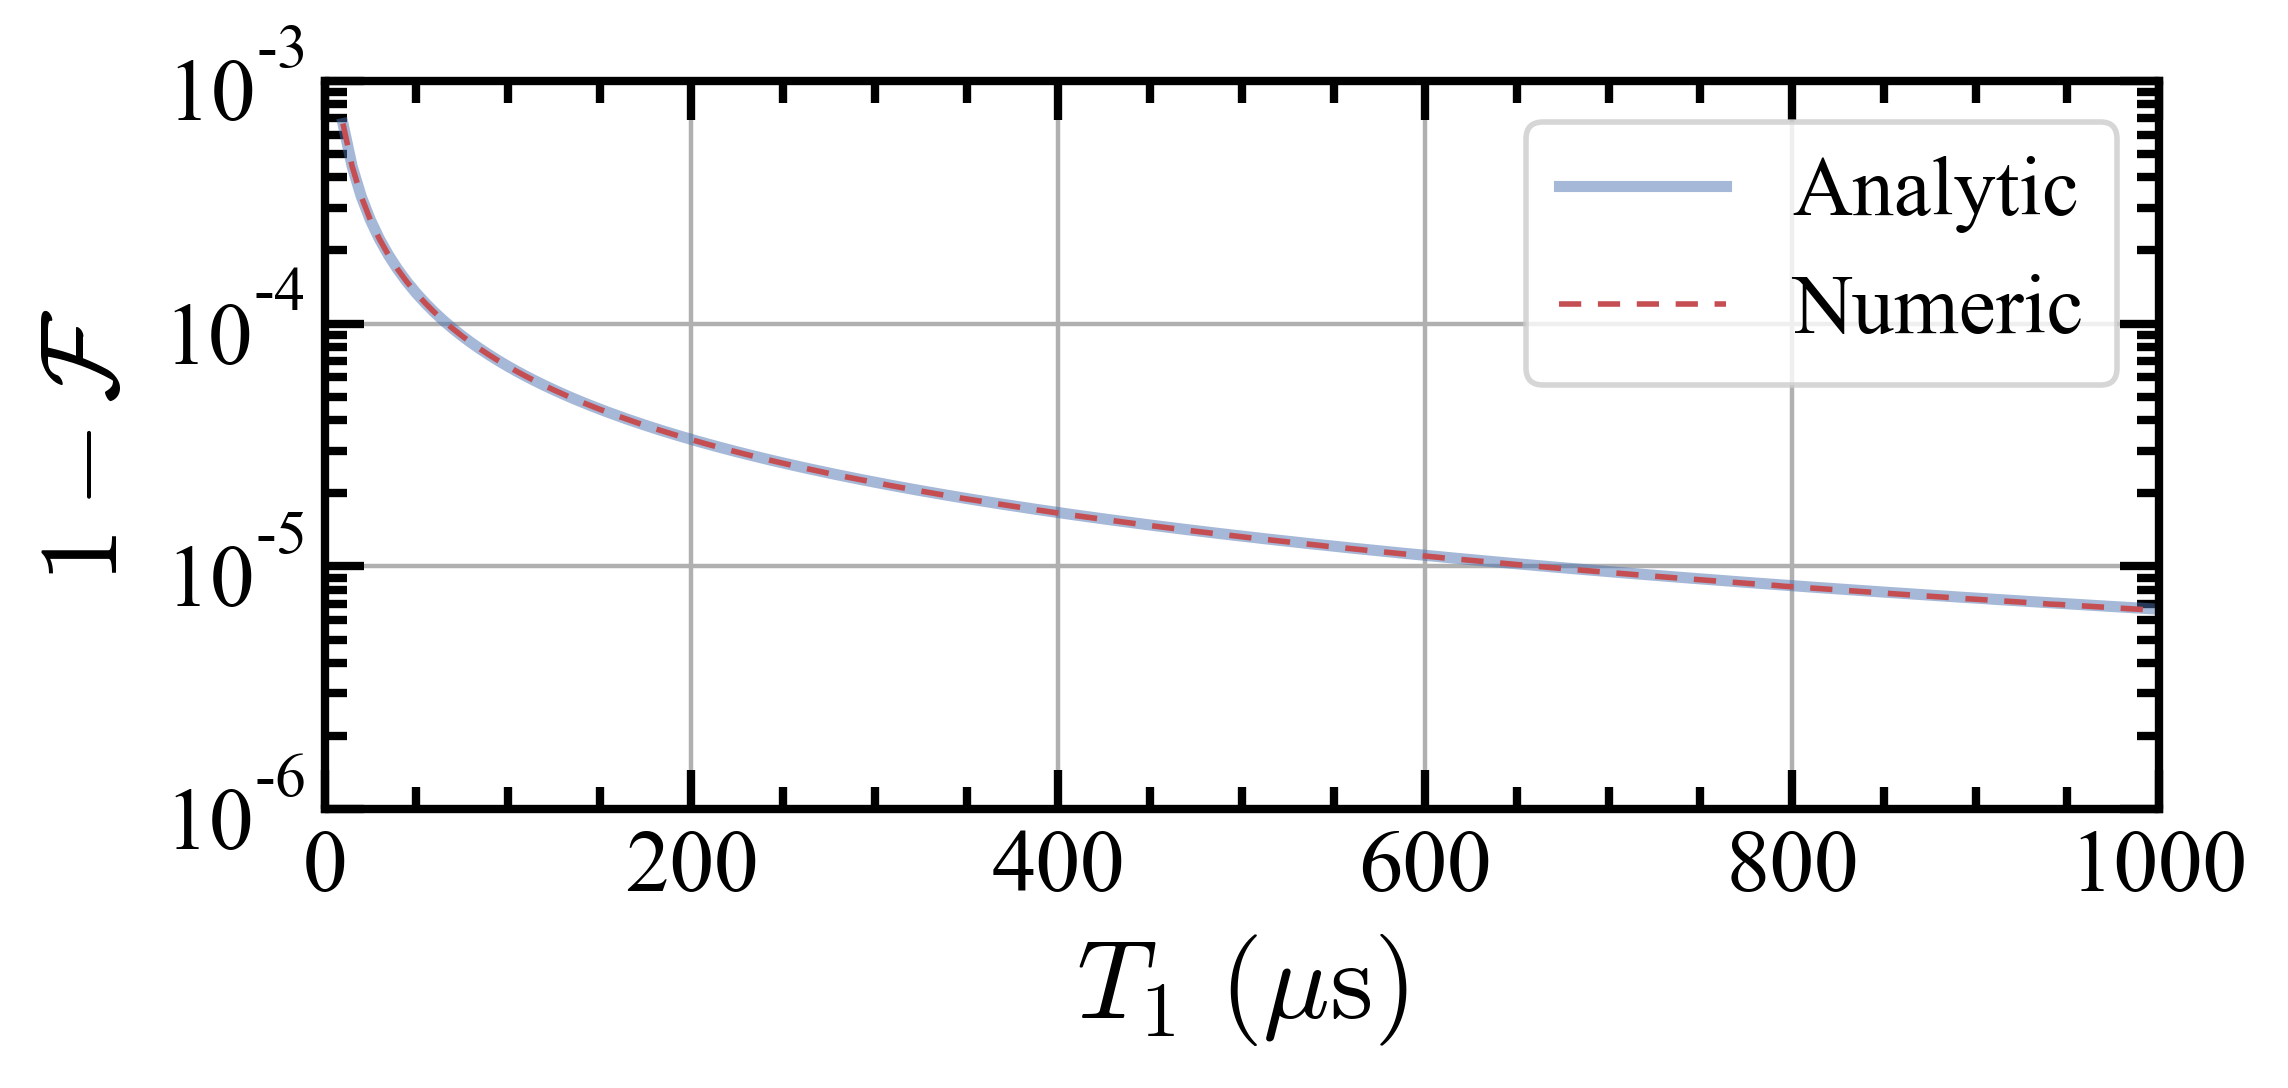

In [21]:
error_array_20 = np.load('1Q decoherence error.npy')
plt.figure(figsize = ([6,3]))
t1_array = np.linspace(10,1000,200)*1e3
Fg=gate_fidel_analytic(t_gate=20, t1=t1_array, t2=1e15,n=1)
plt.semilogy(t1_array*1e-3, 1.0-Fg, alpha = 0.5, label = 'Analytic')


d = 2**1
Fp = 1.0-error_array_20
Fg = (d*Fp+1)/(d+1)
plt.semilogy(t1_array*1e-3, 1-Fg, linestyle = '--', linewidth = 1.0, color = 'C2',label='Numeric')

# Fp = 1.0-error_array_50
# Fg = (d*Fp+1)/(d+1)
# plt.semilogy(t2_array*1e-3, 1-Fg, label=r'$50~\mathrm{ns}$')

plt.xlim([0,1000])
plt.ylim([1e-6,1e-3])
# plt.yticks([1e-5,1e-3,1e-1])
plt.xlabel(r'$T_1~(\mathrm{\mu s})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.legend()
plt.grid()
plt.tight_layout()
figname = '1Qgate_decoherence.pdf'
plt.savefig(figpath+figname)
# plt.text(50,1e-2,r'$\tau_g=50~\mathrm{ns}$')

# Two-qubit gate

## Definitions

In [ ]:
#Define coupled two-level system Hamiltonian
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
XI = tensor(sigmax(), qeye(2))
IX = tensor(qeye(2), sigmax())
YI = tensor(sigmay(), qeye(2))
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())

def two_q_hamiltonian(w1, w2, J):
    return -0.5*w1*ZI - 0.5*w2*IZ + J*XX

w1 = 0.45
w2 = 0.5
J = 0.005

H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

drive_omega_d = -0.05
drive_freq = eig_energies[1] - eig_energies[0] + drive_omega_d

#Gate parameters
T_start = 0
T_gate = 300
shape = 'cos'
T_rise = T_gate/2
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
U_ideal = cphase(np.pi)

## Optimization

In [50]:
def infidelity(x):
    coupl1= x[0]*1e-3*2*np.pi
    coupl2 = x[1]*1e-3*2*np.pi
    H1 = coupl1*XI + coupl2*IX
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)
    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]
    U_real = U

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return (1.0 - fidel)

x0 = [50,100] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = None)
infidel = infidelity(xopt.x)
print (infidel, xopt.x)

5.344393062534092e-05 [62.56918213 97.83687026]


In [51]:
coupl1= xopt.x[0]*1e-3*2*np.pi
coupl2 = xopt.x[1]*1e-3*2*np.pi

H1 = coupl1*XI + coupl2*IX
U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, T_rise = T_rise, omega_d=drive_freq)
u00 = U_t[-1].matrix_element(state_00, state_00)
u01 = U_t[-1].matrix_element(state_01, state_01)
u10 = U_t[-1].matrix_element(state_10, state_10)
u11 = U_t[-1].matrix_element(state_11, state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)

single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()

## PTM

In [ ]:
#With decoherence
t1 = 100000e3 #unit is ns
t2 = 100000e3 #unit is ns
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_ops:
    for q2gate in prep_ops:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)
state_0 = tensor(basis(2,0), basis(2,0))        
        
states_in = []
states_out = []

gamma1 = t1**(-1.0)
gamma2 = t2**(-1.0)
c1 = np.sqrt(gamma1)*(tensor(sigmam(),qeye(2)) + tensor(qeye(2),sigmam()))
c2 = np.sqrt(gamma2/2.0) *(tensor(sigmaz(),qeye(2)) + tensor(qeye(2),sigmaz()))
    
#Ideal case
for i, prep in enumerate(prep_rotations):
    psi_in = prep*state_0
    evol_states_veryideal = U_ideal*psi_in
    psi_out = np.array(ket2dm(evol_states_veryideal))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
ptm_veryideal = tomography.get_process_matrix(states_in, states_out, physical=True)


#No dephasing
states_in = []
states_out = []
for i, prep in enumerate(prep_rotations):
    psi_in = prep*state_0
    evol_states_ideal = gates.evolution_psi_microwave_nonorm_diss(H0, H1, psi0 =psi_in, t_points=t_points, c_ops = [],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    psi_out = np.array(ket2dm(single_qu_z*evol_states_ideal[-1]))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)

#Real case
states_in = []
states_out = []
for i, prep in enumerate(prep_rotations):
    psi_in = prep*state_0
    evol_states_real = gates.evolution_psi_microwave_nonorm_diss(H0, H1, psi0 =psi_in, t_points=t_points, c_ops = [c1,c2],
                                            T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
    psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#     psi_out = np.array(evol_states_real[-1])
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)

In [ ]:
print (1-tomography.process_fidelity(ptm_real, ptm_ideal))

## Sweep t1 time

In [ ]:
t1_array = np.linspace(10,1000,100)*1e3
t2 = 1e15
error_array = np.zeros_like(t1_array)
for t1_idx, t1 in enumerate(t1_array):
    gamma1 = t1**(-1.0)
    gamma2 = t2**(-1.0)
    c1 = np.sqrt(gamma1)*(tensor(sigmam(),qeye(2)) + tensor(qeye(2),sigmam()))
    c2 = np.sqrt(gamma2/2.0) *(tensor(sigmaz(),qeye(2)) + tensor(qeye(2),sigmaz()))
    states_in = []
    states_out = []
    for i, prep in enumerate(prep_rotations):
        psi_in = prep*state_0
        evol_states_real = gates.evolution_psi_microwave_nonorm_diss(H0, H1, psi0 =psi_in, t_points=t_points, c_ops = [c1,c2],
                                                T_gate=T_gate,DRAG = drag, DRAG_coefficient = drag_coeff, shape=shape, omega_d=drive_freq)
        psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
    #     psi_out = np.array(evol_states_real[-1])
        psi_in = np.array(ket2dm(psi_in))
        states_in.append(psi_in)
        states_out.append(psi_out)
    ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
    error_array[t1_idx] = (1-tomography.process_fidelity(ptm_real, ptm_ideal))

In [55]:
np.save('2Q decoherence error.npy', error_array)

## Plotting


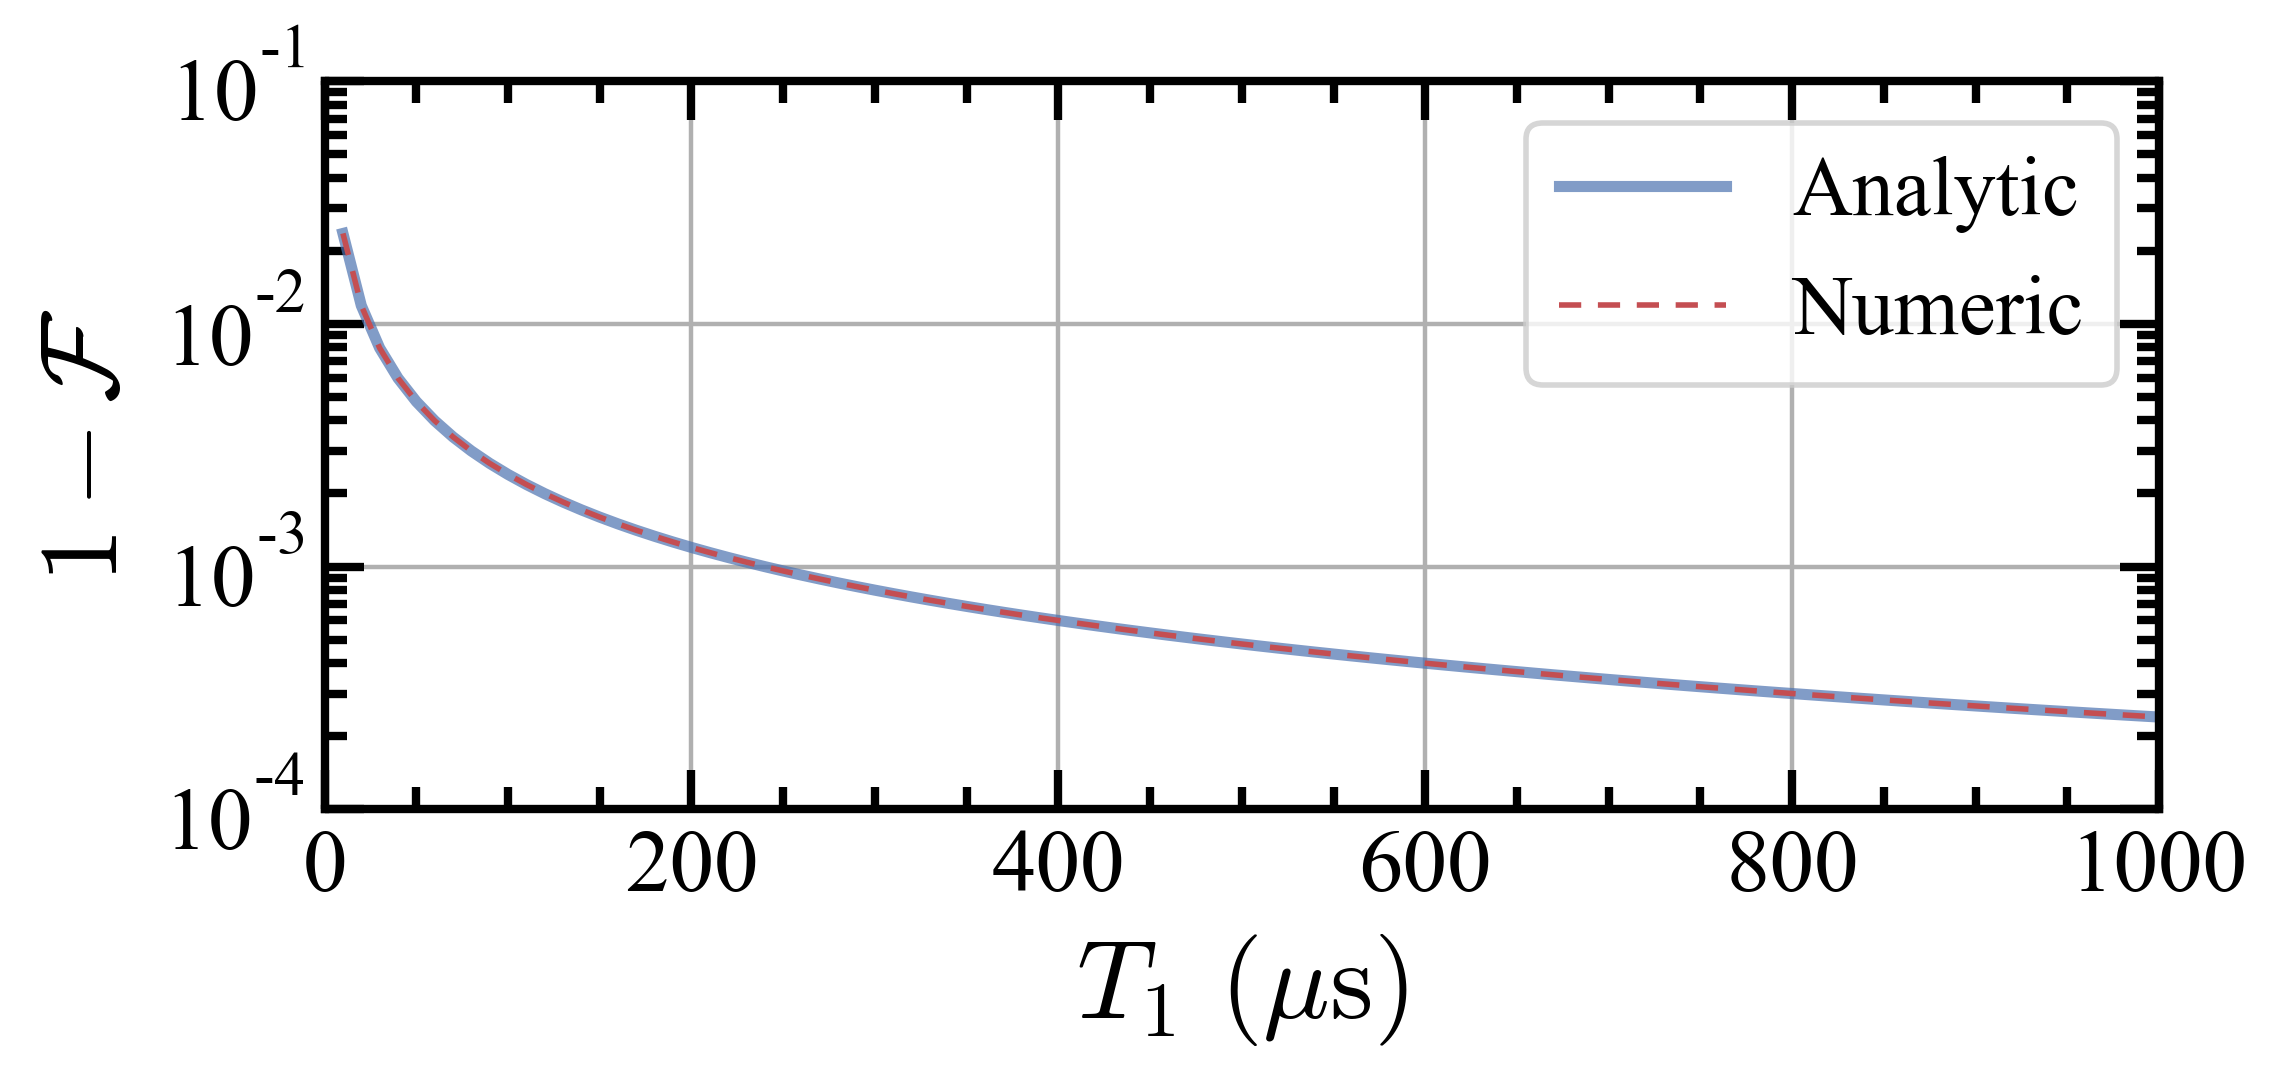

In [22]:
plt.figure(figsize = ([6,3]))
t1_array = np.linspace(10,1000,100)*1e3
Fg = gate_fidel_analytic(t_gate=300, t1=t1_array, t2=1e15,n=2)
plt.semilogy(t1_array*1e-3, 1.0-Fg, alpha = 0.7, label = 'Analytic')

error_array = np.load('2Q decoherence error.npy')
d = 2**2
Fp = 1.0-error_array
Fg = (d*Fp+1)/(d+1)
plt.semilogy(t1_array*1e-3, 1.0-Fg, linestyle = '--', linewidth = 1.0, color = 'C2',label='Numeric')
plt.xlim([0,1000])
plt.ylim([1e-4,1e-1])
plt.xlabel(r'$T_1~(\mathrm{\mu s})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.grid()
plt.legend()
plt.tight_layout()
figname = '2Qgate_decoherence.pdf'
plt.savefig(figpath+figname)

# Three qubits

In [ ]:
sz1 = tensor(sigmaz(), identity(2), identity(2))
sz2 = tensor(identity(2), sigmaz(), identity(2))
sz3 = tensor(identity(2), identity(2), sigmaz())
sx1 = tensor(sigmax(), identity(2), identity(2))
sx2 = tensor(identity(2), sigmax(), identity(2))
sx3 = tensor(identity(2), identity(2), sigmax())
sm1 = tensor(sigmam(), identity(2), identity(2))
sm2 = tensor(identity(2), sigmam(), identity(2))
sm3 = tensor(identity(2), identity(2), sigmam())
    
def toffoli_H_coupled(freq1, freq2, freq3, g):
    return (0.5*freq1*sz1 + 0.5*freq2*sz2 + 0.5*freq3*sz3 + g*sx1*sx2 + g*sx2*sx3)

def toffoli_collapse_ops(t1,t2):
    gamma1 = 1.0/t1
    gamma2 = 1.0/t2
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sm1 + sm2 + sm3)
    c2 = np.sqrt(gamma_phi/2.0) *(sz1 + sz2 + sz3)
    c_ops = [c1, c2]
    return c_ops

freq1 = 5.2541
freq2 = 5.331
freq3 = 5.491
g = 2.74 * 1e-3
T_gate = 340
shape = 'gauss'
drive_freq = freq2
drive_amp = 1
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_nodrive = toffoli_H_coupled(freq1, freq2, freq3, g)
H_drive = drive_amp*(sx1 + sx3)
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0))

t1_toff = 50e3
t2_toff = 60e3
c_ops_toff = toffoli_collapse_ops(t1_toff,t2_toff)

In [ ]:
overlap = 0
for p1_idx in range(6):
    for p2_idx in range(6):
        for p3_idx in range(6):
            psi_ini = tensor(rotation[p1_idx], rotation[p2_idx], rotation[p2_idx])*psi0
            evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi_ini, t=t_points,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            rho_ideal = ket2dm(evol_ideal)
            rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi_ini, t=t_points, c_ops=c_ops_toff,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            overlap = overlap + (rho_real*rho_ideal).tr()
fidel = abs(overlap)/(6.0**3)
print (fidel)

In [ ]:
print (qutip.Options())

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'
infidelity_array = np.load(figpath+'/CR_detune_vs_fidelity_variedJ_TLS.npy')
detuning_array = np.linspace(50,250,51)*1e-3

plt.figure(figsize = [5,4])
# plt.plot(detuning_array*1e3, infidelity_array[:,0], linewidth = 2, label = r'$J_C=1~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,1], linewidth = 2, label = r'$J_C=5~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,2], linewidth = 2, label = r'$J_C=10~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,3], linewidth = 2, label = r'$J_C=20~\mathrm{MHz}$')
plt.yscale("log")
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
# plt.xlim([50,250])
# plt.ylim([5e-5,1e-2])
plt.legend()
plt.tight_layout()
figname = 'CR_gate5.pdf'
plt.savefig(figpath+figname)